Load Requiered Libraries 

In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from keras_tuner.tuners import GridSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
np.random.seed(10)

Load Requiered Datasets

In [154]:
data_micro = pd.read_excel('data_micro.xlsx',index_col=0)
data_macro = pd.read_excel('data_macro.xlsx',index_col=0)

In [155]:
data_micro.head()

,Price,Open,High,Low
Date,,,,
2002-01-01,5164.8,5217.4,5362.3,5052.8
2002-02-01,5101.0,5164.8,5238.0,5015.5
2002-03-01,5271.8,5101.0,5331.6,5101.0
2002-04-01,5165.6,5271.8,5292.3,5116.0
2002-05-01,5085.1,5165.6,5282.2,5016.9


In [156]:
data_macro.head()

,Price,Open,High,Low,GDP,Bank Rate,CPI,OECD CCI,Unemployment Rate
Date,,,,,,,,,
2002-01-01,5164.8,5217.4,5362.3,5052.8,74.4,4.0,0.8,102.4653,5.1
2002-02-01,5101.0,5164.8,5238.0,5015.5,74.3,4.0,1.1,102.6777,5.2
2002-03-01,5271.8,5101.0,5331.6,5101.0,74.5,4.0,1.6,102.7930,5.2
2002-04-01,5165.6,5271.8,5292.3,5116.0,74.4,4.0,1.5,102.8708,5.1
2002-05-01,5085.1,5165.6,5282.2,5016.9,74.6,4.0,1.5,102.9090,5.2


Scale Data

In [157]:
scaler_micro = MinMaxScaler()
scaler_macro = MinMaxScaler()

In [158]:
scaled_micro = scaler_micro.fit_transform(data_micro)
scaled_macro = scaler_macro.fit_transform(data_macro)

In [159]:
scaled_df_micro = pd.DataFrame(scaled_micro)
scaled_df_macro = pd.DataFrame(scaled_macro)

Scaling Data Complete

Split Test, Validation, and Training Data for Micro Data

In [160]:
y = scaled_df_micro.iloc[:, 0]
x_micro = scaled_df_micro.iloc[:, 1:]

# First, split the data into a training set and a temporary set
x_train_micro, x_temp_micro, y_train_micro, y_temp_micro = train_test_split(x_micro, y, test_size=0.3, shuffle=False)

# Then, split the temporary set into a validation set and a test set
x_val_micro, x_test_micro, y_val_micro, y_test_micro = train_test_split(x_temp_micro, y_temp_micro, test_size=0.5, shuffle=False)

Split Test, Validation, and Training Data for Macro Data

In [161]:
x_macro = scaled_df_macro.iloc[:, 1:]

# First, split the data into a training set and a temporary set
x_train_macro, x_temp_macro, y_train_macro, y_temp_macro = train_test_split(x_macro, y, test_size=0.3, shuffle=False)

# Then, split the temporary set into a validation set and a test set
x_val_macro, x_test_macro, y_val_macro, y_test_macro = train_test_split(x_temp_macro, y_temp_macro, test_size=0.5, shuffle=False)

Splitting Data Complete

Deep Learning Section 

Create Window Sub Section

In [162]:
def create_window(x, y, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(x)):
        dataX.append(x.iloc[i - n_past:i].values)
        dataY.append(y.iloc[i])
    return np.array(dataX), np.array(dataY)

Create Windows for the Micro Data

In [163]:
trainX_micro, trainY_micro = create_window(x_train_micro, y_train_micro, 4)
valX_micro, valY_micro = create_window(x_val_micro, y_val_micro, 4)
testX_micro, testY_micro = create_window(x_test_micro, y_test_micro, 4)

Create Windows for the Macro Data

In [164]:
trainX_macro, trainY_macro = create_window(x_train_macro, y_train_macro, 4)
valX_macro, valY_macro = create_window(x_val_macro, y_val_macro, 4)
testX_macro, testY_macro = create_window(x_test_macro, y_test_macro, 4)

In [165]:
print(trainX_micro.shape)
print(trainY_micro.shape)
print(valX_micro.shape)
print(valY_micro.shape)
print(testX_micro.shape)
print(testY_micro.shape)

print(trainX_macro.shape)
print(trainY_macro.shape)
print(valX_macro.shape)
print(valY_macro.shape)
print(testX_macro.shape)
print(testY_macro.shape)

(173, 4, 3)
(173,)
(34, 4, 3)
(34,)
(34, 4, 3)
(34,)
(173, 4, 8)
(173,)
(34, 4, 8)
(34,)
(34, 4, 8)
(34,)


Windows Completed

Find Optimal Micro Hyper Parameters

In [166]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(
        units=hp.Choice('units', [50, 100, 200, 400]),  # Only test for 200 and 400 neurons
        activation='relu',
        return_sequences=False))  # Only return the last output for each input sample
    model.add(layers.Dense(1))  # Add this line
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'adadelta']),  # Only test for 'adam' and 'adadelta' optimizers
        loss='mse',
        metrics=['mse'])
    return model

In [167]:
tuner1 = GridSearch(
    build_model,
    objective='val_mse',
    max_trials=8,  # number of different hyperparameter combinations to try
    executions_per_trial=5,  # number of models to build for each trial for robustness
    directory='my_dir',
    project_name='helloworld_micro_valid')

In [168]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop training when `val_loss` is no longer improving
    mode='min',  # "min" means that training will be stopped when the quantity monitored has stopped decreasing
    patience=3  # Number of epochs with no improvement after which training will be stopped
)

In [169]:
tuner1.search(trainX_micro, trainY_micro,
             epochs=500,  # Increase the number of epochs since we're using early stopping
             validation_data=(valX_micro, valY_micro),  # Use validation data for validation
             callbacks=[early_stopping])  # Pass the callback to `search`

Trial 8 Complete [00h 29m 33s]
val_mse: 0.26057661771774293

Best val_mse So Far: 0.004121268540620804
Total elapsed time: 01h 10m 43s


tuner.results_summary()

In [170]:
tuner1.get_best_hyperparameters()[0].values

{'units': 200, 'optimizer': 'adam'}

Find Macro Optimal Hyper Parameters

In [172]:
#Inialise New Tuner
tuner2 = GridSearch(
    build_model,
    objective='val_mse',
    max_trials=8,  # number of different hyperparameter combinations to try
    executions_per_trial=5,  # number of models to build for each trial for robustness
    directory='my_dir_macro',
    project_name='helloworld_2_validate_macro')

In [173]:
tuner2.search(trainX_macro, trainY_macro,
             epochs=500,  # Increase the number of epochs since we're using early stopping
             validation_data=(valX_macro, valY_macro),  # Use validation data for validation
             callbacks=[early_stopping])  # Pass the callback to `search`

Trial 8 Complete [00h 27m 07s]
val_mse: 0.22836098968982696

Best val_mse So Far: 0.0037335842847824098
Total elapsed time: 01h 09m 02s


In [174]:
tuner2.get_best_hyperparameters()[0].values

{'units': 400, 'optimizer': 'adam'}

Optimal Parameters Macro Found

Optimal Parameters for Both Models Found

Now Produce Model with Best Hyperparameters

Micro Model

Build Micro Model

In [177]:
# Get the best hyperparameters
best_hyperparameters_micro = tuner1.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters
model_micro = tuner1.hypermodel.build(best_hyperparameters_micro)

# Compile the model with Mean Absolute Error as the loss function
model_micro.compile(loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
model_micro.fit(trainX_micro, trainY_micro, epochs=500, validation_data=(valX_micro, valY_micro))

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1571 - mean_squared_error: 0.1571 - val_loss: 0.1189 - val_mean_squared_error: 0.1189
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0047 - val_mean_square

Moving Average Function

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Plot Loss Over Epochs for Micro

In [ ]:
# Number of iterations
n_iterations = 30

# Arrays to store loss values
train_loss_values = np.zeros((n_iterations, 500))
val_loss_values = np.zeros((n_iterations, 500))

# Iterate over the number of iterations
for i in range(n_iterations):
    # Fit the model and save the history
    history_micro = model_micro.fit(trainX_micro, trainY_micro, epochs=500, validation_data=(valX_micro, valY_micro))
    
    # Save the loss values
    train_loss_values[i, :] = history_micro.history['loss']
    val_loss_values[i, :] = history_micro.history['val_loss']

# Calculate the average loss values
avg_train_loss = np.mean(train_loss_values, axis=0)
avg_val_loss = np.mean(val_loss_values, axis=0)

# Calculate moving averages
mov_avg_train_loss = moving_average(avg_train_loss, n=3)
mov_avg_val_loss = moving_average(avg_val_loss, n=3)

# Find the minimum values
min_train_loss_index = np.argmin(mov_avg_train_loss)
min_val_loss_index = np.argmin(mov_avg_val_loss)


In [179]:
# Plot the average training loss and moving average
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(np.arange(len(mov_avg_train_loss)), mov_avg_train_loss, label='Moving Average Training Loss')
plt.axvline(min_train_loss_index, color='r', linestyle='--', label='Min Training Loss')

# Plot the average validation loss and moving average
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.plot(np.arange(len(mov_avg_val_loss)), mov_avg_val_loss, label='Moving Average Validation Loss')
plt.axvline(min_val_loss_index, color='b', linestyle='--', label='Min Validation Loss')

# Add title and labels
plt.title('Average Loss Over Epochs for Micro Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Print the epochs with the minimum loss
print(f"Epoch with minimum training loss for Micro Model: {min_train_loss_index+1}")
print(f"Epoch with minimum validation loss for Micro Model: {min_val_loss_index+1}")

(34, 1)


Build Macro Model

In [ ]:
# Get the best hyperparameters
best_hyperparameters_macro = tuner2.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters
model_macro = tuner2.hypermodel.build(best_hyperparameters_micro)

# Compile the model with Mean Absolute Error as the loss function
model_macro.compile(loss='mean_absolute_error', metrics=['mean_squared_error'])

# Train the model with validation data
model_macro.fit(trainX_macro, trainY_macro, epochs=500, validation_data=(valX_macro, valY_macro))

Plot Loss over Epochs Macro

In [ ]:
# Number of iterations
n_iterations = 30

# Arrays to store loss values
train_loss_values = np.zeros((n_iterations, 500))
val_loss_values = np.zeros((n_iterations, 500))

# Iterate over the number of iterations
for i in range(n_iterations):
    # Fit the model and save the history
    history_macro = model_macro.fit(trainX_macro, trainY_macro, epochs=500, validation_data=(valX_macro, valY_macro))
    
    # Save the loss values
    train_loss_values[i, :] = history_macro.history['loss']
    val_loss_values[i, :] = history_macro.history['val_loss']

# Calculate the average loss values
avg_train_loss = np.mean(train_loss_values, axis=0)
avg_val_loss = np.mean(val_loss_values, axis=0)

# Calculate moving averages
mov_avg_train_loss = moving_average(avg_train_loss, n=3)
mov_avg_val_loss = moving_average(avg_val_loss, n=3)

# Find the minimum values
min_train_loss_index = np.argmin(mov_avg_train_loss)
min_val_loss_index = np.argmin(mov_avg_val_loss)

In [ ]:
# Plot the average training loss and moving average
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(np.arange(len(mov_avg_train_loss)), mov_avg_train_loss, label='Moving Average Training Loss')
plt.axvline(min_train_loss_index, color='r', linestyle='--', label='Min Training Loss')

# Plot the average validation loss and moving average
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.plot(np.arange(len(mov_avg_val_loss)), mov_avg_val_loss, label='Moving Average Validation Loss')
plt.axvline(min_val_loss_index, color='b', linestyle='--', label='Min Validation Loss')

# Add title and labels
plt.title('Average Loss Over Epochs for Macro Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Print the epochs with the minimum loss
print(f"Epoch with minimum training loss: {min_train_loss_index+1}")
print(f"Epoch with minimum validation loss: {min_val_loss_index+1}")

Epoch Plotting Complete

Inverse Transform Micro

In [185]:
# Create a dummy array with the same shape as your original data
dummy_array_micro = np.zeros((predicted_values_micro.shape[0], 4))

# Replace the first column of the dummy array with your predicted values
dummy_array_micro[:,0] = predicted_values_micro[:,0]

In [186]:
# Inverse transform the dummy array
inverse_transformed_predictions_micro = scaler_micro.inverse_transform(dummy_array_micro)

# Extract the first column, which contains your inverse transformed predictions
inverse_transformed_predictions_micro = inverse_transformed_predictions_micro[:,0]

Inverse Transform Macro

In [188]:
dummy_array_macro = np.zeros((predicted_values_macro.shape[0], 9))

# Replace the first column of the dummy array with your predicted values
dummy_array_macro[:,0] = predicted_values_macro[:,0]

In [189]:
inverse_transformed_predictions_macro = scaler_macro.inverse_transform(dummy_array_macro)

# Extract the first column, which contains your inverse transformed predictions
inverse_transformed_predictions_macro = inverse_transformed_predictions_macro[:,0]

In [190]:
print(inverse_transformed_predictions_macro)
len(inverse_transformed_predictions_macro)

[6619.46247945 6695.17599331 6552.94883889 6118.35305882 5961.86574994
 5882.25020875 5609.87349017 5886.62611275 6292.4154035  6600.14003907
 6660.56796044 6734.51602683 6610.1573559  6642.75485861 6826.42404419
 6948.61155304 7035.93867903 7344.57397977 7481.81528    7604.49395663
 7693.05902591 7714.04191411 7816.32760507 7799.53718474 7551.63578284
 7331.66679208 6745.87252766 6142.90493251 5655.30763785 5196.78810247
 4829.07483998 4698.41005085 4479.51548962 4268.41370623]


34

Inverse Transform True Dependent Values

Inverse Transformations Complete

Plot the Predictions

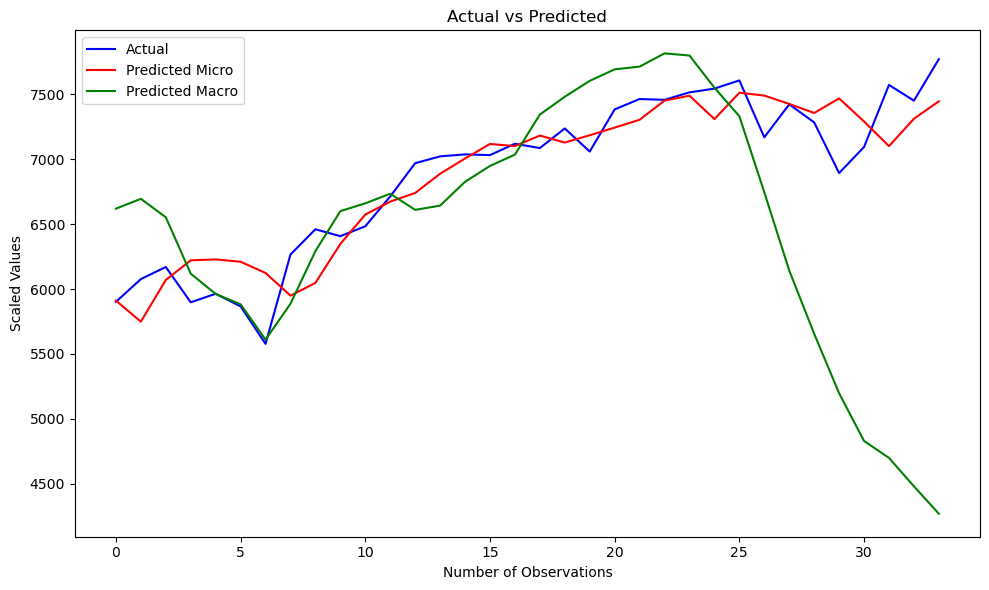

In [191]:
# Assuming `testY_micro` are your true values
# and `inverse_transformed_predictions_macro` are your predicted values

plt.figure(figsize=(10,6))

# Plotting actual values
true_values = data_micro.iloc[-34:, 0]
plt.plot(true_values.values, color='blue', label='Actual')

# Plotting micro values
plt.plot(inverse_transformed_predictions_micro, color='red', label='Predicted Micro')

# Plotting macro values again
plt.plot(inverse_transformed_predictions_macro, color='green', label='Predicted Macro')

plt.title('Actual vs Predicted')
plt.xlabel('Number of Observations')
plt.ylabel('Scaled Values')
plt.legend()

plt.tight_layout()
plt.show()

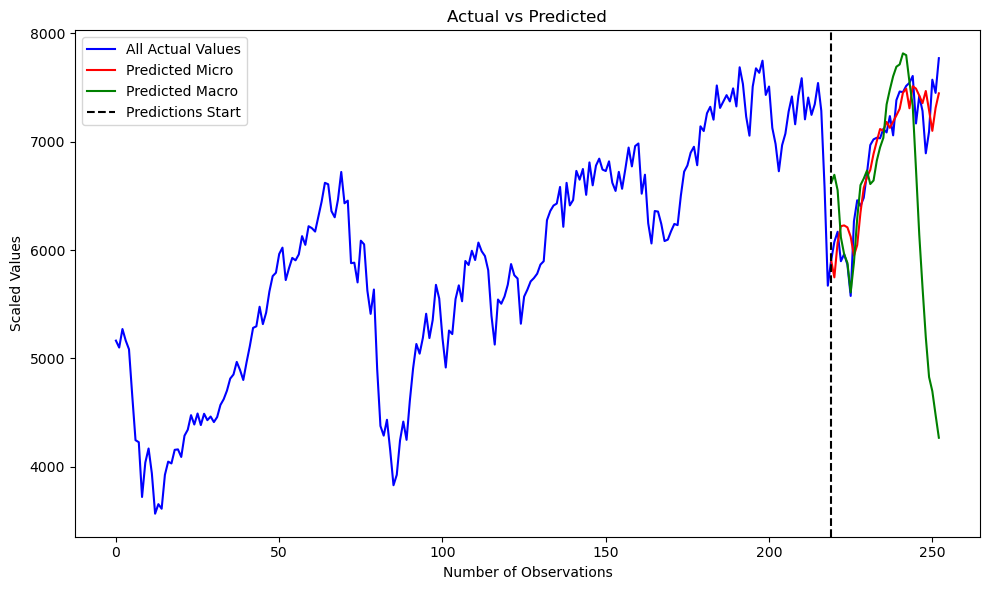

In [192]:
# Select all values of the first column of `data_micro`
all_values = data_micro.iloc[:, 0]

plt.figure(figsize=(10,6))

# Plotting all actual values
plt.plot(all_values.values, color='blue', label='All Actual Values')

# Calculate the starting point for the predictions
start_point = len(all_values) - 34

# Plotting micro values
plt.plot(range(start_point, start_point + len(inverse_transformed_predictions_micro)), inverse_transformed_predictions_micro, color='red', label='Predicted Micro')

# Plotting macro values
plt.plot(range(start_point, start_point + len(inverse_transformed_predictions_macro)), inverse_transformed_predictions_macro, color='green', label='Predicted Macro')

# Draw a vertical line at the point where the predictions start
plt.axvline(x=start_point, color='black', linestyle='--', label='Predictions Start')

plt.title('Actual vs Predicted')
plt.xlabel('Number of Observations')
plt.ylabel('Scaled Values')
plt.legend()

plt.tight_layout()
plt.show()

Plotting Predictions Complete

Micro Metrics

In [94]:
from sklearn.metrics import mean_squared_error

# Initialize lists to store results for micro model
mae_results_micro = []
mape_results_micro = []
rmse_results_micro = []  # list to store RMSE results

# Initialize DataFrame to store all predictions
df_predictions_micro = pd.DataFrame()

# Run micro model 30 times
for i in range(30):
    # Train the micro model
    model_micro.fit(trainX_micro, trainY_micro, epochs=100,verbose=0)

    # Make predictions with micro model
    predictions_micro = model_micro.predict(testX_micro)

    # Descale the predictions
    dummy_array_micro = np.zeros((predictions_micro.shape[0], 4))
    dummy_array_micro[:,0] = predictions_micro[:,0]
    inverse_transformed_predictions_micro = scaler_micro.inverse_transform(dummy_array_micro)
    inverse_transformed_predictions_micro = inverse_transformed_predictions_micro[:,0]

    # Save predictions to DataFrame
    df_predictions_micro[f'Iteration_{i+1}'] = inverse_transformed_predictions_micro

    # Calculate metrics for micro model
    mae_micro = mean_absolute_error(true_values, inverse_transformed_predictions_micro)
    mape_micro = mean_absolute_percentage_error(true_values, inverse_transformed_predictions_micro)
    rmse_micro = mean_squared_error(true_values, inverse_transformed_predictions_micro, squared=False)  # calculate RMSE

    # Store results for micro model
    mae_results_micro.append(mae_micro)
    mape_results_micro.append(mape_micro)
    rmse_results_micro.append(rmse_micro)  # store RMSE results

# Calculate mean and standard deviation of results for micro model
mean_mae_micro = np.mean(mae_results_micro)
std_mae_micro = np.std(mae_results_micro)

mean_mape_micro = np.mean(mape_results_micro)
std_mape_micro = np.std(mape_results_micro)

mean_rmse_micro = np.mean(rmse_results_micro)  # calculate mean RMSE
std_rmse_micro = np.std(rmse_results_micro)  # calculate standard deviation of RMSE

print("Final Results")
print(f"Mean MAE: {mean_mae_micro}, Std Dev MAE: {std_mae_micro}")
print(f"Mean MAPE: {mean_mape_micro}, Std Dev MAPE: {std_mape_micro}")
print(f"Mean RMSE: {mean_rmse_micro}, Std Dev RMSE: {std_rmse_micro}")  # print RMSE results

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Final Results
Mean MAE: 443.5719266358763, Std Dev MAE: 188.1796373926244
Mean MAPE: 0.06363468158140206, Std Dev MAPE: 0.026233742941207353
Mean RMSE: 522.2065466709654, Std Dev RMSE: 225.63684005036788


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [96]:
df_predictions_micro.to_csv('df_predictions_micro.csv', index=False)

In [97]:
# Read the CSV file into a DataFrame
df_predictions_micro_rd = pd.read_csv('df_predictions_micro.csv')

# Calculate the average of each row and save to an array
predictions_micro_average = df_predictions_micro.mean(axis=1).values

In [98]:
predictions_micro_average

array([5447.52586885, 5348.08315809, 5887.18095693, 6267.12312778,
       6158.55770634, 6150.36961361, 6053.8276454 , 5905.61068315,
       5988.26854933, 6331.13008353, 6537.42393574, 6582.04335468,
       6597.60498682, 6726.98416099, 6870.55717361, 6940.60962793,
       6800.11819196, 6796.14329973, 6704.28992061, 6818.6201566 ,
       6790.6093925 , 6921.36193194, 6936.92537672, 6949.61407827,
       6674.74424047, 6760.31226742, 6854.35978826, 6909.92850655,
       6648.73029895, 6820.4331588 , 6828.83441668, 6539.48971393,
       6626.55941956, 7059.67655071])

Macro Model

In [99]:
# Initialize lists to store results for macro model
mae_results_macro = []
mape_results_macro = []
rmse_results_macro = []  # list to store RMSE results

# Initialize DataFrame to store all predictions
df_predictions_macro = pd.DataFrame()

# Run macro model 30 times
for i in range(30):
    # Train the macro model
    model_macro.fit(trainX_macro, trainY_macro, epochs=100,verbose=0)

    # Make predictions with macro model
    predictions_macro = model_macro.predict(testX_macro)

    # Descale the predictions
    dummy_array_macro = np.zeros((predictions_macro.shape[0], 9))
    dummy_array_macro[:,0] = predictions_macro[:,0]
    inverse_transformed_predictions_macro = scaler_macro.inverse_transform(dummy_array_macro)
    inverse_transformed_predictions_macro = inverse_transformed_predictions_macro[:,0]

    # Save predictions to DataFrame
    df_predictions_macro[f'Iteration_{i+1}'] = inverse_transformed_predictions_macro

    # Calculate metrics for macro model
    mae_macro = mean_absolute_error(true_values, inverse_transformed_predictions_macro)
    mape_macro = mean_absolute_percentage_error(true_values, inverse_transformed_predictions_macro)
    rmse_macro = mean_squared_error(true_values, inverse_transformed_predictions_macro, squared=False)  # calculate RMSE

    # Store results for macro model
    mae_results_macro.append(mae_macro)
    mape_results_macro.append(mape_macro)
    rmse_results_macro.append(rmse_macro)  # store RMSE results

# Calculate mean and standard deviation of results for macro model
mean_mae_macro = np.mean(mae_results_macro)
std_mae_macro = np.std(mae_results_macro)

mean_mape_macro = np.mean(mape_results_macro)
std_mape_macro = np.std(mape_results_macro)

mean_rmse_macro = np.mean(rmse_results_macro)  # calculate mean RMSE
std_rmse_macro = np.std(rmse_results_macro)  # calculate standard deviation of RMSE

print("Final Results")
print(f"Mean MAE: {mean_mae_macro}, Std Dev MAE: {std_mae_macro}")
print(f"Mean MAPE: {mean_mape_macro}, Std Dev MAPE: {std_mape_macro}")
print(f"Mean RMSE: {mean_rmse_macro}, Std Dev RMSE: {std_rmse_macro}")  # print RMSE results

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Final Results
Mean MAE: 1695.3506144640144, Std Dev MAE: 746.3724714874265
Mean MAPE: 0.23289240638912106, Std Dev MAPE: 0.10052556708273136
Mean RMSE: 2875.650396913554, Std Dev RMSE: 1291.4665199080168


/Users/alexandersamuel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [100]:
df_predictions_macro.to_csv('df_predictions_macro.csv', index=False)

In [101]:
# Read the CSV file into a DataFrame
df_predictions_macro_rd = pd.read_csv('df_predictions_macro.csv')

# Calculate the average of each row and save to an array
predictions_macro_average = df_predictions_macro.mean(axis=1).values

In [102]:
predictions_macro_average

array([6610.74527038, 6576.87887579, 6547.36933158, 6185.70320489,
       6022.657503  , 5789.90792138, 5691.02190921, 5977.90092462,
       6343.12991392, 6596.83589993, 6628.18115868, 6768.48422178,
       6577.01526674, 6552.67079449, 6800.74580081, 6961.98825703,
       6980.17862249, 7194.3963058 , 7414.34209974, 7420.12782234,
       7319.04550915, 7149.05363395, 6818.29745603, 6410.97854726,
       5864.51091783, 5134.49481483, 4418.27443811, 3332.27885901,
       2258.46775973, 1483.4923975 ,  987.56114038,  884.7745606 ,
        708.69869322,  548.08714849])

Plot Averaged Values

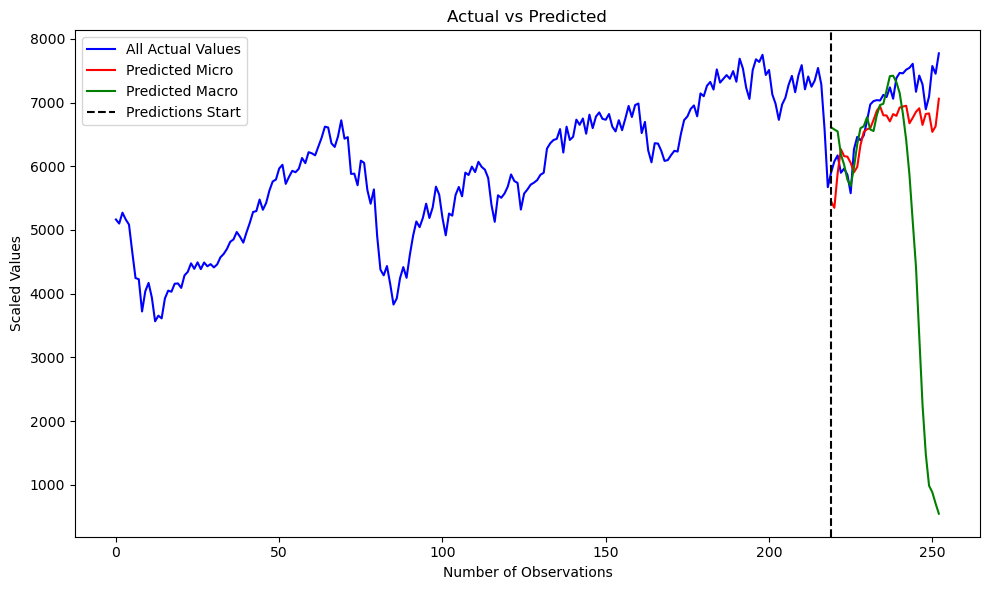

In [103]:
# Select all values of the first column of `data_micro`
all_values = data_micro.iloc[:, 0]

plt.figure(figsize=(10,6))

# Plotting all actual values
plt.plot(all_values.values, color='blue', label='All Actual Values')

# Calculate the starting point for the predictions
start_point = len(all_values) - 34

# Plotting micro values
plt.plot(range(start_point, start_point + len(predictions_micro_average)), predictions_micro_average, color='red', label='Predicted Micro')

# Plotting macro values
plt.plot(range(start_point, start_point + len(predictions_macro_average)), predictions_macro_average, color='green', label='Predicted Macro')

# Draw a vertical line at the point where the predictions start
plt.axvline(x=start_point, color='black', linestyle='--', label='Predictions Start')

plt.title('Actual vs Predicted')
plt.xlabel('Number of Observations')
plt.ylabel('Scaled Values')
plt.legend()

plt.tight_layout()
plt.show()